In [38]:
import numpy as np
import matplotlib.pyplot as plt
import get_data as gd
import Preprocessing as p
import SimpleITK as sitk
import seaborn as sns
from scipy import stats, signal
import statistics
import ImageViewer as iv
import pandas as pd
import os

%matplotlib inline

In [4]:
def create_dataframe(folder_path, image_prefix, mask_suffix):
    """
    Returns a dataframe with information of the images in the folder_path
    
    folder_path: path to folder with images
    image_prefix: prefix of image files
    mask_suffix: suffix of mask files
    """
    patientPaths, patientNames, imagePaths, maskPaths = gd.get_paths(folder_path, image_prefix, mask_suffix)
    df = p.dataframe(patientPaths, patientNames, imagePaths, maskPaths)
    df = p.dimensions(df)
    return df

In [5]:
def intensities(df):
    """
    Returns a list of arrays containing the pixel intensities of the images in the dataframe
    
    df: dataframe with image paths
    """
    
    pixel_values = []
    img_sizes = []
    
    for path in df['imagePaths']:
        print(path)
        image = sitk.ReadImage(path)
        image_array = sitk.GetArrayFromImage(image)
        img_sizes.append(np.shape(image_array))
        pixel_values.append(image_array.flatten())
    
    return pixel_values, img_sizes

In [6]:
def pixel_distribution(pixel_list):
    """
    Plots the distribution of pixels in the images 
    """
    fig, ax = plt.subplots(figsize=(11,8))
    for i in range(len(pixel_list)):
        sns.kdeplot(data=pixel_list[i], ax=ax)
    plt.xlabel('Pixel intensity')
    plt.show()

## Training functions

In [7]:
def landmarks(pixel_list, min_percentile, max_percentile):
    """
    Returns the minimum and maximum percentile values (p_1j, p_2j) for image j,
    and the position of the bimodal node for image j.
    """
    min_percentiles = []
    max_percentiles = []
    bimodals_index = []
    bimodals = []
    max_intensities = []
    min_intensities = []

    
    plt.figure(figsize=(11,8))
    plt.xlabel('Pixel intensity', fontsize='x-large')
    plt.ylabel('Density', fontsize='x-large')
    
    for i in range(len(pixel_list)):
        print('i:', i)
        #Calculate percentiles for the pixels in the image
        min_percentiles.append(np.percentile(pixel_list[i], min_percentile))
        max_percentiles.append(np.percentile(pixel_list[i], max_percentile))
        
        max_intensities.append(max(pixel_list[i]))
        min_intensities.append(min(pixel_list[i]))
        
        #Find the bimodal point in the distribution
        max_y = []
        x,y = sns.kdeplot(pixel_list[i]).get_lines()[i].get_data() #Creates a list of x- and y-values used to plot the pixel distribution
        max_index = np.ndarray.tolist(signal.argrelextrema(y, np.greater)[0]) #Finds indexes of the maximum points in the distribution
        for j in max_index:
            max_y.append(y[j]) #Adds the maximum value to a list
        max_y.sort() #Sorts the maximum values

        #Check that the second highest point is after the highest point of the distribution, in order
        #to add the correct bimodal point.
        print(len(max_y))
        
        if len(max_y) > 1:
            if (np.where(y==max_y[-2])[0][0] < np.where(y==max_y[-1])[0][0]):
                bimodal_j = np.ndarray.tolist(x[np.where(y==max_y[-1])])
                bimodals.append(max_y[-1])
            else:
                bimodal_j = np.ndarray.tolist(x[np.where(y==max_y[-2])])
                bimodals.append(max_y[-2])
                
            bimodals_index.append(bimodal_j[0])
            
        else:
            bimodal_j = np.ndarray.tolist(x[np.where(y==max_y[-1])])
            bimodals.append(max_y[-1])
            
            bimodals_index.append(bimodal_j[0])
    
    #Visualize and plot the pixel distributions together with the bimodal point.
    for k in range(len(bimodals_index)):
        plt.plot(bimodals_index[k], bimodals[k], '*', markersize=10)
        
    return min_percentiles, max_percentiles, bimodals_index, max_intensities, min_intensities

In [8]:
def check_s_values(bimodals, min_percentiles, max_percentiles, s1, s2):
    """
    Checks that the choice of s-values fullfills Theorem 2 in the following articel:
    chrome-extension://dagcmkpagjlhakfdhnbomgmjdpkdklff/enhanced-reader.html?pdf=https%3A%2F%2Fbrxt.mendeley.com%2Fdocument%2Fcontent%2F3875ee52-3498-3bf0-84c7-94b63dac20f5
    """
    
    a = []
    b = []
    
    for i in range(len(bimodals)):
        if (bimodals[i] > min_percentiles[i] and bimodals[i] < max_percentiles[i]):
            a.append(bimodals[i]-min_percentiles[i])
            b.append(max_percentiles[i]-bimodals[i])
        else:
            print('Condition not fulfilled')
    
    min_a = min(a)
    max_a = max(a)
    min_b = min(b)
    max_b = max(b)
    
    print(min_a)
    print(max_a)
    print(min_b)
    print(max_a)
    
    condition = (max_a + max_b) * max(max_a/min_a, max_b/min_b)
    print('Condition which must be fullfilled:', condition)
    
    if (s2 - s1) >= condition:
        print('Condition fullfilled')
    else:
        print('Choose new values for s_1 and s_2')

In [9]:
def map_percentiles(bimodals, min_percentiles, max_percentiles, s1, s2):
    """
    
    """
    new_bimodals = []
    
    for j in range(len(bimodals)):
        new_bimodal = s1 + ((bimodals[j] - min_percentiles[j])/(max_percentiles[j] - min_percentiles[j]))*(s2-s1)
        new_bimodals.append(new_bimodal)
    
    new_bimodal_mean = round(statistics.mean(new_bimodals))
    
    return new_bimodal_mean

## Transformation functions

In [10]:
def standardizer_function(bimodal_s, bimodal_i, p_1i, p_2i, s1, s2, m_1i, m_2i, x):
    
    if (x >= m_1i) and (x <= bimodal_i):
        tau = bimodal_s + (x - bimodal_i) * (s1-bimodal_s)/(p_1i-bimodal_i)
    else:
        tau = bimodal_s + (x - bimodal_i) * (s2-bimodal_s)/(p_2i-bimodal_i)
    
    return tau

In [11]:
def map_histogram_sections(bimodal_s, bimodal_i, p_1i, p_2i, s1, s2, m_1i, m_2i):
    
    stand_s1 = []
    stand_s2 = []
    stand_bimodal_s = []
    
    for i in range(len(bimodal_i)):
        stand_s1.append(standardizer_function(bimodal_s, bimodal_i[i], p_1i[i], p_2i[i], s1, s2, m_1i[i], m_2i[i], x=p_1i[i]))
        stand_s2.append(standardizer_function(bimodal_s, bimodal_i[i], p_1i[i], p_2i[i], s1, s2, m_1i[i], m_2i[i], x=p_2i[i]))
        stand_bimodal_s.append(standardizer_function(bimodal_s, bimodal_i[i], p_1i[i], p_2i[i], s1, s2, m_1i[i], m_2i[i], x=bimodal_i[i]))
    
    return stand_s1, stand_s2, stand_bimodal_s

In [90]:
def map_intensities(intensities, bimodal_s, bimodal_i, p_1i, p_2i, s1, s2, m_1i, m_2i):
    
    stand_intensities = []
    
    for i in range(len(bimodal_i)):
        print(i)
        stand_intensities_temp = []
        for j in range(len(intensities[i])):
            stand_intensities_temp.append(standardizer_function(bimodal_s, bimodal_i[i], p_1i[i], p_2i[i], s1, s2, m_1i[i], m_2i[i], x=intensities[i][j]))
        stand_intensities.append(np.array(stand_intensities_temp))
    return stand_intensities

## LARC-RRP

### Training

In [13]:
LARC = create_dataframe('/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped', 'image', 'label.nii')

In [14]:
LARC_train = LARC[:10]

In [15]:
pixel_values_LARC, image_sizes_LARC = intensities(LARC_train)

/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-003/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-004/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-005/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-006/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-007/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-008/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-009/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-001/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-011/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-013/image.nii


In [74]:
print(pixel_values_LARC)

[array([321, 310, 275, ..., 154, 158, 164], dtype=int16), array([377, 387, 407, ...,  94,  94, 100], dtype=int16), array([279, 238, 203, ..., 236, 238, 244], dtype=int16), array([389, 405, 390, ..., 290, 294, 313], dtype=int16), array([359, 376, 381, ..., 102, 111, 116], dtype=int16), array([358, 351, 342, ..., 200, 195, 165], dtype=int16), array([ 16,  19,  24, ..., 229, 257, 254], dtype=int16), array([280, 294, 290, ..., 308, 292, 269], dtype=int16), array([0, 0, 0, ..., 0, 0, 0], dtype=int16), array([0, 0, 0, ..., 0, 0, 0], dtype=int16)]


0
9
1
10
2
4
3
10
4
9
5
5
6
7
7
12
8
7
9
6
[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 3.0, 0.0, 0.0]
[477.0, 479.0, 462.0, 470.0, 571.0, 516.0, 617.0, 457.0, 597.0, 581.0]
[309.05670771090433, 256.83519751803055, 593.8993913334874, 267.41741689920286, 274.15909234211694, 291.8038981578805, 270.4323291581216, 234.70384189454228, 262.8752812588947, 82.82000047740237]


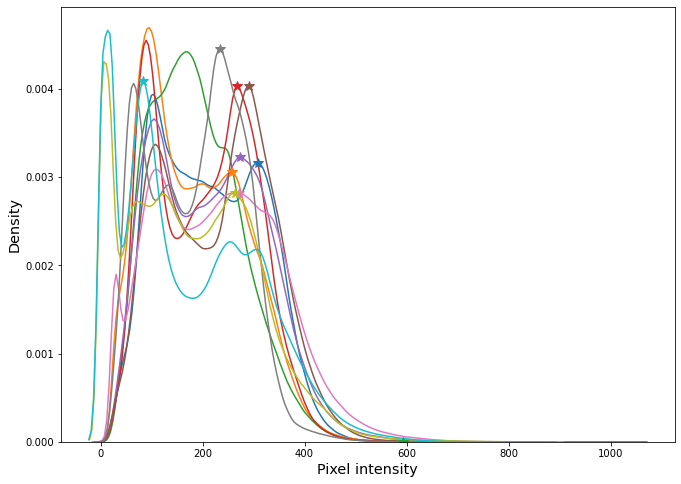

In [16]:
min_p_LARC, max_p_LARC, bimodals_LARC, max_i_LARC, min_i_LARC = landmarks(pixel_values_LARC, 0, 99.8)
print(min_p_LARC)
print(max_p_LARC)
print(bimodals_LARC)

In [17]:
s1_LARC = 1
s2_LARC = 3200
check_s_values(bimodals_LARC, min_p_LARC, max_p_LARC, s1_LARC, s2_LARC)

Condition not fulfilled
82.82000047740237
309.05670771090433
167.94329228909567
309.05670771090433
Condition which must be fullfilled: 3012.3390200782355
Condition fullfilled


In [18]:
new_bimodal_LARC = map_percentiles(bimodals_LARC, min_p_LARC, max_p_LARC, s1_LARC, s2_LARC)
print(new_bimodal_LARC)

1797


### Transforming

In [44]:
LARC_trans = LARC[10:20]

In [45]:
pixel_values_LARC_trans, img_sizes_LARC_trans = intensities(LARC_trans)

/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-014/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-015/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-016/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-017/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-018/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-019/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-020/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-021/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-022/image.nii
/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped/LARC-RRP-023/image.nii


0
4
1
4
2
5
3
3
4
9
5
9
6
6
7
5
8
4
9
7
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]
[644.0, 639.0, 531.0, 420.0, 490.0, 547.0, 526.0, 570.0, 501.0, 488.0]
[362.21058851314405, 99.59823570456189, 306.28964063129706, 254.24521645452168, 317.3344307322079, 72.08075165952714, 275.5159758531302, 207.55067347669151, 308.45879807128966, 610.3331103534404]
[1008, 892, 865, 630, 840, 926, 831, 877, 755, 795]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 1]


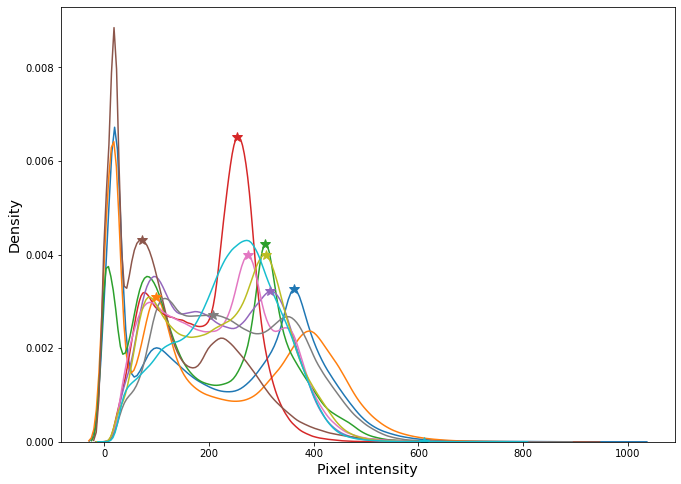

In [46]:
min_p_LARC_trans, max_p_LARC_trans, bimodals_LARC_trans, max_i_LARC_trans, min_i_LARC_trans = landmarks(pixel_values_LARC_trans, 0, 99.8)
print(min_p_LARC_trans)
print(max_p_LARC_trans)
print(bimodals_LARC_trans)
print(max_i_LARC_trans)
print(min_i_LARC_trans)

In [47]:
stand_s1_LARC, stand_s2_LARC, stand_bimodal_s_LARC = map_histogram_sections(new_bimodal_LARC, bimodals_LARC_trans, min_p_LARC_trans, max_p_LARC_trans, s1_LARC, s2_LARC, min_i_LARC_trans, max_i_LARC_trans)

print(stand_s1_LARC)
print(stand_s2_LARC)
print(stand_bimodal_s_LARC)

[1.0, 1.0, 1.0, 1.0, 1.0000000000002274, 1.0, 1.0, 1.0, 1.0, 0.9999999999997726]
[3200.0, 3200.0, 3200.0, 3200.0, 3200.0, 3200.0, 3200.0, 3200.0, 3200.0, 1436.425032939147]
[1797.0, 1797.0, 1797.0, 1797.0, 1797.0, 1797.0, 1797.0, 1797.0, 1797.0, 1797.0]


In [91]:
new_pixels_LARC = map_intensities(pixel_values_LARC_trans, new_bimodal_LARC, bimodals_LARC_trans, min_p_LARC_trans, max_p_LARC_trans, s1_LARC, s2_LARC, min_i_LARC_trans, max_i_LARC_trans)


0
1
2
3
4
5
6
7
8
9


In [94]:
print(new_pixels_LARC)

[array([1., 1., 1., ..., 1., 1., 1.]), array([ 1.        ,  1.        , 19.03244794, ...,  1.        ,
        1.        ,  1.        ]), array([1., 1., 1., ..., 1., 1., 1.]), array([ 460.16301446,  361.26636519,  368.33041157, ..., 1828.78165481,
       1854.17458713, 1904.96045177]), array([2224.93588783, 2151.80607942, 2013.67199686, ..., 1956.79325699,
       1973.04432552, 1997.42092833]), array([1., 1., 1., ..., 1., 1., 1.]), array([1967.74576322, 1973.34691884, 2023.75731944, ..., 1702.03032637,
       1669.31820471, 1649.69093172]), array([2433.56458497, 2390.98483969, 2406.46838343, ..., 2464.53167245,
       2383.24306783, 2313.567121  ]), array([ 338.70474582,  385.28471077,  385.28471077, ..., 1844.66411664,
       1815.51710839, 1859.23762076]), array([614.07681078, 770.29349815, 752.60859014, ..., 702.5013508 ,
       708.39632013, 740.81865147])]


0
4
1
4
2
5
3
4
4
11
5
4
6
5
7
7
8
7
9
3


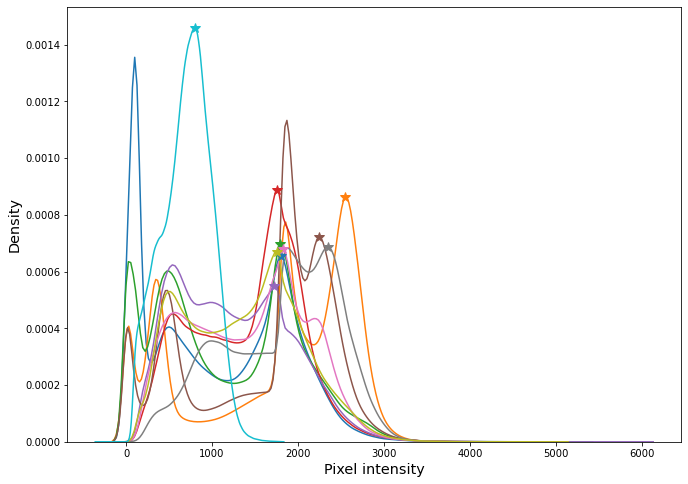

In [95]:
min_p_LARC_new, max_p_LARC_new, bimodals_LARC_new, max_i_LARC_new, min_i_LARC_new = landmarks(new_pixels_LARC, 0, 99.8)


## OxyTarget

In [25]:
Oxy = create_dataframe('/Volumes/LaCie/MasterThesis_Ingvild/Oxy_cropped', 'T2', 'an.nii')

In [26]:
Oxy_train = Oxy[:10]
pixel_values_Oxy, image_sizes_Oxy = intensities(Oxy_train)

/Volumes/LaCie/MasterThesis_Ingvild/Oxy_cropped/Oxytarget_103_PRE/T2.nii
/Volumes/LaCie/MasterThesis_Ingvild/Oxy_cropped/Oxytarget_106_PRE/T2.nii
/Volumes/LaCie/MasterThesis_Ingvild/Oxy_cropped/Oxytarget_108_PRE/T2.nii
/Volumes/LaCie/MasterThesis_Ingvild/Oxy_cropped/Oxytarget_110_PRE/T2.nii
/Volumes/LaCie/MasterThesis_Ingvild/Oxy_cropped/Oxytarget_111_PRE/T2.nii
/Volumes/LaCie/MasterThesis_Ingvild/Oxy_cropped/Oxytarget_113_PRE/T2.nii
/Volumes/LaCie/MasterThesis_Ingvild/Oxy_cropped/Oxytarget_115_PRE/T2.nii
/Volumes/LaCie/MasterThesis_Ingvild/Oxy_cropped/Oxytarget_116_PRE/T2.nii
/Volumes/LaCie/MasterThesis_Ingvild/Oxy_cropped/Oxytarget_118_PRE/T2.nii
/Volumes/LaCie/MasterThesis_Ingvild/Oxy_cropped/Oxytarget_120_PRE/T2.nii


## Reconstruct images

In [50]:
def reconstruct_image_array(array, image_size):
    
    im = np.reshape(array, image_size)
    im = im.astype(int)
    im = sitk.GetImageFromArray(im)
    
    return im

In [51]:
def reconstruct_images(array, image_size):
    
    images = []
    
    for i in range(len(array)):
        images.append(reconstruct_image_array(array[i], image_size[i]))
    
    return images

In [30]:
def plot_single_image(ax, img):
    """
    Plots a single image and contour.
    """
    #plt.figure()
    #ax = plt.subplot(111)
    ax.imshow(img, 'gray')#, vmin=0, vmax=1)
    ax.axis('off')
    #ax.contour(contour[0][..., 0], 1, levels=[0.5], colors='yellow')
    #plt.show()

In [31]:
def plot_images(images_b, images_a, slice_number):    
    """
    Plots 4 single images with contours.
    """
    plt.figure(figsize=(15,15))
    for i in range(4):
        ax = plt.subplot(4, 2, 2*i+1)
        plot_single_image(ax, images_b[i][slice_number])#[..., 0], targets[i])
        
        ax = plt.subplot(4, 2, 2*i+2)
        plot_single_image(ax, images_a[i][slice_number])#[..., 1], targets[i])

    plt.show()

In [35]:
def create_destination_paths(dst_main_folder):

    dst_subfolder_list = [f for f in os.listdir(dst_main_folder) 
                          if os.path.isdir(os.path.join(dst_main_folder, f))]

    dst_list = []

    for i in range(len(dst_subfolder_list)):
        dst_list.append(dst_main_folder + '/' + dst_subfolder_list[i])
        
    return dst_list

In [57]:
def save_images(dataframe, image_arrays, destination_paths, image_filename, mask_filename):
    
    for i in range(len(dataframe['imagePaths'])):
        
        image = image_arrays[i]
        mask = sitk.ReadImage(dataframe['maskPaths'][i])
        
        sitk.WriteImage(image, os.path.join(destination_paths[i], image_filename))
        sitk.WriteImage(mask, os.path.join(destination_paths[i], mask_filename))

In [96]:
im_before_LARC = reconstruct_images(pixel_values_LARC_trans, img_sizes_LARC_trans)
im_after_LARC = reconstruct_images(new_pixels_LARC, img_sizes_LARC_trans)


In [97]:
print(len(im_after_LARC))

10


In [98]:
dst_list_LARC = create_destination_paths('/Volumes/LaCie/MasterThesis_Ingvild/LARC_cropped_HistStand')
dst_list_LARC = dst_list_LARC[10:20]
print(len(dst_list_LARC))
save_images(LARC, im_after_LARC, dst_list_LARC, 'image.nii', '1 RTSTRUCT LARC_MRS1-label.nii')

10


IndexError: list index out of range

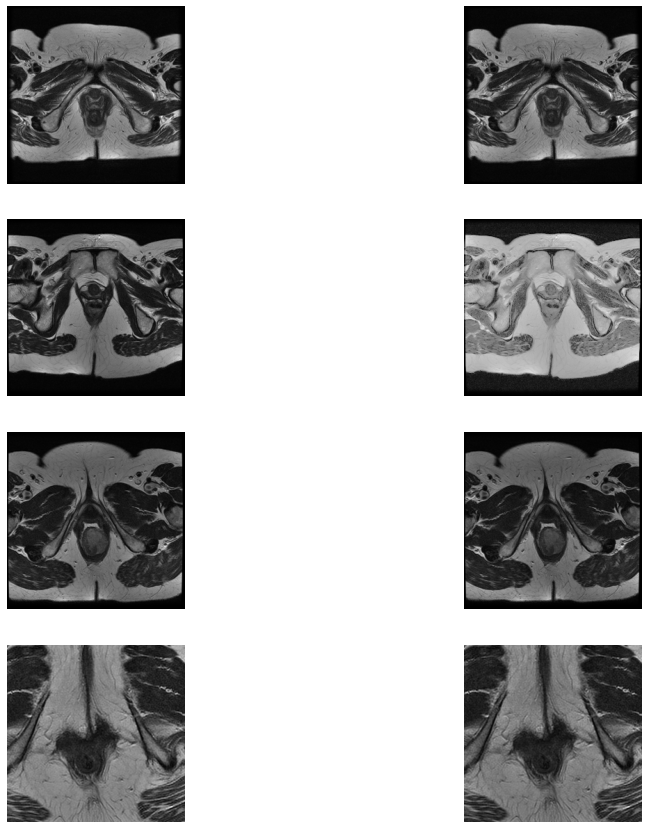

In [34]:
before = im_before[10:14]
after = im_after[10:14]
plot_images(before, after, 5)